In [1]:
import pandas as pd
import numpy as np
import os
import math
import scipy.stats
import pickle
import xgboost as xgb
import random
from re import sub
import time
import plotly.graph_objects as go

In [2]:
import tensorflow as tf
import shap

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [3]:
## options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
### Brilliant Earth
## loose diamonds
if os.path.exists(os.path.abspath('./brilliant-earth.pickle')):
    with open('brilliant-earth.pickle', 'rb') as handle:
        be_diamond_data = pickle.load(handle)
        
be_df=pd.DataFrame(data=be_diamond_data)[['shape', 'price', 'carat','cut','color', 'clarity']]
be_df['vendor'] = 'Brilliant Earth'
be_df['is_lab'] = False

## lab diamonds
if os.path.exists(os.path.abspath('./brilliant-earth-lab.pickle')):
    with open('brilliant-earth-lab.pickle', 'rb') as handle:
        be_lab_diamond_data = pickle.load(handle)
        
bel_df = pd.DataFrame(data=be_lab_diamond_data)[['shape', 'price', 'carat','cut','color', 'clarity']]
bel_df['vendor'] = 'Brilliant Earth'
bel_df['is_lab'] = True


In [5]:
be_df.sample(1)

shape  price  carat          cut color clarity           vendor  is_lab
70204  Round   2330    0.7  Super Ideal     I    VVS2  Brilliant Earth   False

In [6]:
be_df.cut.unique()

array(['Super Ideal', 'Ideal', 'Good', 'Very Good', 'Fair'], dtype=object)

In [7]:
### Blue Nile
if os.path.exists(os.path.abspath('./blue-nile.pickle')):
    with open('blue-nile.pickle', 'rb') as handle:
        bn_diamond_data = pickle.load(handle)

bn_df_raw = pd.DataFrame(data = bn_diamond_data)[['shapeName','price','carat','cut','color','clarity']]

bn_df = pd.DataFrame()
bn_df['shape'] = bn_df_raw.shapeName.apply(lambda x: x[0])
bn_df['price'] = bn_df_raw.price.apply(lambda x: float(sub(r'[^\d.]', '', x[0])))
bn_df['carat'] = bn_df_raw.carat.apply(lambda x: x[0])
bn_df['cut'] = bn_df_raw.cut.apply(lambda x: x[0]['label']).map({
    'Good': 'Good', 
    'Very Good': 'Very Good',
    'Ideal': 'Ideal',
    'Astor Ideal': 'Super Ideal',
})
bn_df['color'] = bn_df_raw.color.apply(lambda x: x[0])
bn_df['clarity'] = bn_df_raw.clarity.apply(lambda x: x[0])
bn_df['vendor'] = 'Blue Nile'
bn_df['is_lab'] = False

In [8]:
bn_df.head()

shape  price carat        cut color clarity     vendor  is_lab
0  Round  250.0  0.23  Very Good     E     SI1  Blue Nile   False
1  Round  277.0  0.23  Very Good     F     SI1  Blue Nile   False
2  Round  277.0  0.23  Very Good     F     SI1  Blue Nile   False
3  Round  280.0  0.23  Very Good     D     SI1  Blue Nile   False
4  Round  286.0  0.23       Good     D     SI2  Blue Nile   False

In [9]:
### Jammes Allen
## loose diammonds
if os.path.exists(os.path.abspath('./james-allen.pickle')):
    with open('james-allen.pickle', 'rb') as handle:
        ja_diamond_data = pickle.load(handle)
        

ja_df = pd.DataFrame(data=ja_diamond_data)[['stone','price']]

ja_df['clarity'] = ja_df.stone.apply(lambda x: x['clarity']['name'])
ja_df['shape'] = ja_df.stone.apply(lambda x: x['shape']['name']).map({'round':'Round'})
ja_df['color'] = ja_df.stone.apply(lambda x: x['color']['name'])
ja_df['cut'] = ja_df.stone.apply(lambda x: x['cut']['name']).map({
    'Good': 'Good', 
    'Very Good': 'Very Good',
    'Ideal': 'Ideal',
    'True Hearts': 'Super Ideal',
    'Excellent': 'Ideal',
})
ja_df['carat'] = ja_df.stone.apply(lambda x: x['carat'])
ja_df['vendor'] = 'James Allen'
ja_df['is_lab'] = False

## lab diamonds
if os.path.exists(os.path.abspath('./james-allen-lab.pickle')):
    with open('james-allen-lab.pickle', 'rb') as handle:
        ja_lab_diamond_data = pickle.load(handle)

jal_df = pd.DataFrame(data=ja_lab_diamond_data)[['stone','price']]

jal_df['clarity'] = jal_df.stone.apply(lambda x: x['clarity']['name'])
jal_df['shape'] = jal_df.stone.apply(lambda x: x['shape']['name']).map({'round':'Round'})
jal_df['color'] = jal_df.stone.apply(lambda x: x['color']['name'])
jal_df['cut'] = jal_df.stone.apply(lambda x: x['cut']['name']).map({
    'Good': 'Good', 
    'Very Good': 'Very Good',
    'Ideal': 'Ideal',
    'True Hearts': 'Super Ideal',
    'Excellent': 'Ideal',
})
jal_df['carat'] = jal_df.stone.apply(lambda x: x['carat'])
jal_df['vendor'] = 'James Allen'
jal_df['is_lab'] = True


In [10]:
## put it all together
diamond_df = be_df.append([bel_df, bn_df, ja_df, jal_df])\
    [['shape','price','carat','cut','color','clarity','vendor','is_lab']]\
    .reset_index(drop=True)

diamond_df['price'] = diamond_df.price.astype(float)
diamond_df['carat'] = diamond_df.carat.astype(float)
diamond_df['log_price'] = diamond_df.price.apply(lambda x: math.log10(x))

In [11]:
print(diamond_df.shape)
diamond_df.head()

(576820, 9)


shape  price  carat          cut color clarity           vendor  is_lab  \
0  Round  480.0   0.25  Super Ideal     F     VS1  Brilliant Earth   False   
1  Round  480.0   0.25  Super Ideal     E     SI1  Brilliant Earth   False   
2  Round  480.0   0.25  Super Ideal     F     SI1  Brilliant Earth   False   
3  Round  480.0   0.25  Super Ideal     G     VS2  Brilliant Earth   False   
4  Round  480.0   0.25  Super Ideal     G     VS2  Brilliant Earth   False   

   log_price  
0   2.681241  
1   2.681241  
2   2.681241  
3   2.681241  
4   2.681241

In [12]:
diamond_df.describe()

price          carat      log_price
count  576816.000000  576820.000000  576816.000000
mean     4130.012807       0.891218       3.341713
std      7627.499091       0.590134       0.450712
min       245.000000       0.180000       2.389166
25%       990.000000       0.500000       2.995635
50%      2090.000000       0.730000       3.320146
75%      4200.000000       1.090000       3.623249
max    432810.000000       5.000000       5.636297

In [13]:
diamond_df.price.sort_values(ascending=True).head()

209184    245.0
314744    250.0
205466    250.0
304743    250.0
304744    250.0
Name: price, dtype: float64

### relationship between carat and price

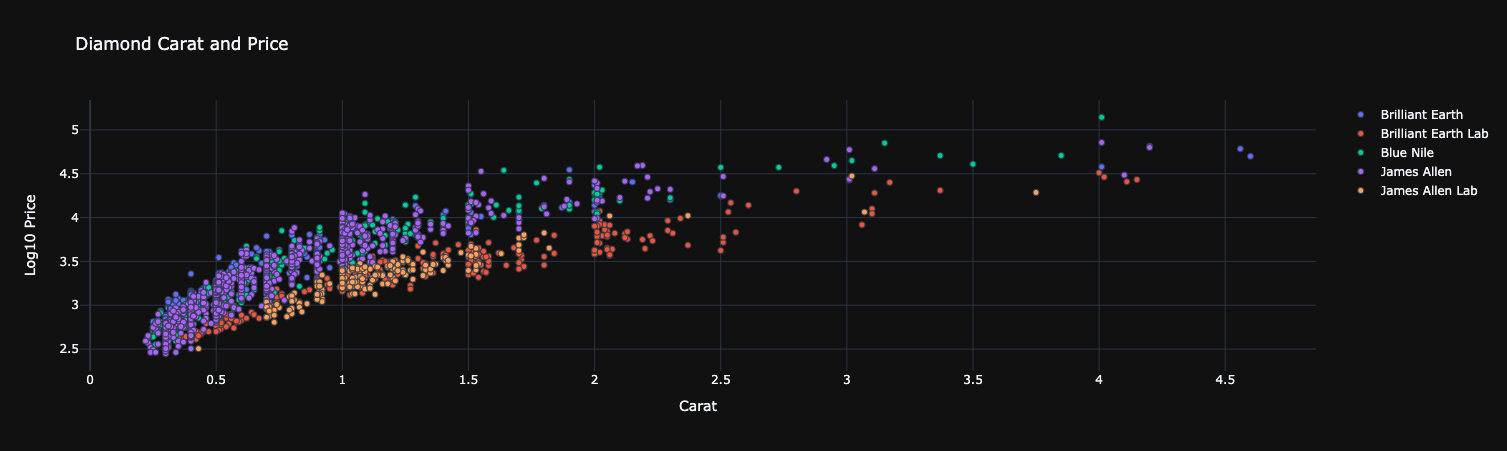

In [14]:
### plot it?
graph_df = diamond_df.sample(2000, random_state=0)

# Define indices corresponding to flower categories, using pandas label encoding
index_vals = graph_df['vendor'].astype('category').cat.codes

fig = go.Figure()

fig.add_trace(
    go.Scatter(
    x = graph_df[(graph_df.vendor=='Brilliant Earth') & (graph_df.is_lab==False)].carat
    , y = graph_df[(graph_df.vendor=='Brilliant Earth') & (graph_df.is_lab==False)].log_price
    , name = 'Brilliant Earth'
    , mode='markers'
    ,  marker=dict(
        colorscale='agsunset',
        line_width=1
    )
    )
)

fig.add_trace(
    go.Scatter(
    x = graph_df[(graph_df.vendor=='Brilliant Earth') & (graph_df.is_lab==True)].carat
    , y = graph_df[(graph_df.vendor=='Brilliant Earth') & (graph_df.is_lab==True)].log_price
    , name = 'Brilliant Earth Lab'
    , mode='markers'
    ,  marker=dict(
        colorscale='agsunset',
        line_width=1
    )
    )
)

fig.add_trace(
    go.Scatter(
    x = graph_df[graph_df.vendor=='Blue Nile'].carat
    , y = graph_df[graph_df.vendor=='Blue Nile'].log_price
    , name = 'Blue Nile'
    , mode='markers'
    ,  marker=dict(
        colorscale='agsunset',
        line_width=1
    )
    )
)

fig.add_trace(
    go.Scatter(
    x = graph_df[(graph_df.vendor=='James Allen') & (graph_df.is_lab==False)].carat
    , y = graph_df[(graph_df.vendor=='James Allen') & (graph_df.is_lab==False)].log_price
    , name = 'James Allen'
    , mode='markers'
    ,  marker=dict(
        colorscale='agsunset',
        line_width=1
    )
    )
)

fig.add_trace(
    go.Scatter(
    x = graph_df[(graph_df.vendor=='James Allen') & (graph_df.is_lab==True)].carat
    , y = graph_df[(graph_df.vendor=='James Allen') & (graph_df.is_lab==True)].log_price
    , name = 'James Allen Lab'
    , mode='markers'
    ,  marker=dict(
        colorscale='agsunset',
        line_width=1
    )
    )
)

# dark theme 
fig.layout.template = 'plotly_dark'

fig.update_layout(title = 'Diamond Carat and Price',
                  xaxis_title='Carat',
                  yaxis_title='Log10 Price', 
                 )

fig.show()

In [15]:
r = scipy.stats.pearsonr(graph_df.log_price, graph_df.carat)

print(r, r[0]**2)

(0.8210200030141874, 0.0) 0.6740738453494163


### Regression on Log Price

In [16]:
# transform diamond data
diamond_df_t = pd.get_dummies(data=diamond_df, prefix='', prefix_sep='')
diamond_df_t.is_lab = diamond_df_t.is_lab.map({True:1, False:0})

# rid ourselves of any nans 
# drop categories to avoid collinearity
diamond_df_t = diamond_df_t[~np.any(np.isnan(diamond_df_t),1)]\
    .drop(['Fair', 'K', 'SI2' , 'Blue Nile','Emerald', 'price'], axis=1)

print(diamond_df_t.shape)
diamond_df_t.head()

(576816, 33)


carat  is_lab  log_price  Asscher  Cushion  Heart  Marquise  Oval  Pear  \
0   0.25       0   2.681241        0        0      0         0     0     0   
1   0.25       0   2.681241        0        0      0         0     0     0   
2   0.25       0   2.681241        0        0      0         0     0     0   
3   0.25       0   2.681241        0        0      0         0     0     0   
4   0.25       0   2.681241        0        0      0         0     0     0   

   Princess  Radiant  Round  Good  Ideal  Super Ideal  Very Good  D  E  F  G  \
0         0        0      1     0      0            1          0  0  0  1  0   
1         0        0      1     0      0            1          0  0  1  0  0   
2         0        0      1     0      0            1          0  0  0  1  0   
3         0        0      1     0      0            1          0  0  0  0  1   
4         0        0      1     0      0            1          0  0  0  0  1   

   H  I  J  FL  I1  IF  SI1  VS1  VS2  VVS1  VVS2  Brilliant Earth  \
0  0  0  0   0   0   0    0    1    0     0     0                1   
1  0  0  0   0   0   0    1    0    0     0     0                1   
2  0  0  0   0   0   0    1    0    0     0     0                1   
3  0  0  0   0   0   0    0    0    1     0     0                1   
4  0  0  0   0   0   0    0    0    1     0     0                1   

   James Allen  
0            0  
1            0  
2            0  
3            0  
4            0

In [17]:
## test and train
train_dataset = diamond_df_t.copy().sample(frac=0.8, random_state=0)
test_dataset = diamond_df_t.copy().drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('log_price')
test_labels = test_features.pop('log_price')

train_dataset.shape

(461453, 33)

In [18]:
import statsmodels.api as sm
from scipy import stats

train_features2 = sm.add_constant(train_features)

mod = sm.OLS(train_labels, train_features2)
results = mod.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                 7.088e+04
Date:                Tue, 16 Feb 2021   Prob (F-statistic):               0.00
Time:                        17:27:08   Log-Likelihood:             1.2348e+05
No. Observations:              461453   AIC:                        -2.469e+05
Df Residuals:                  461420   BIC:                        -2.465e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.3435      0.009    2

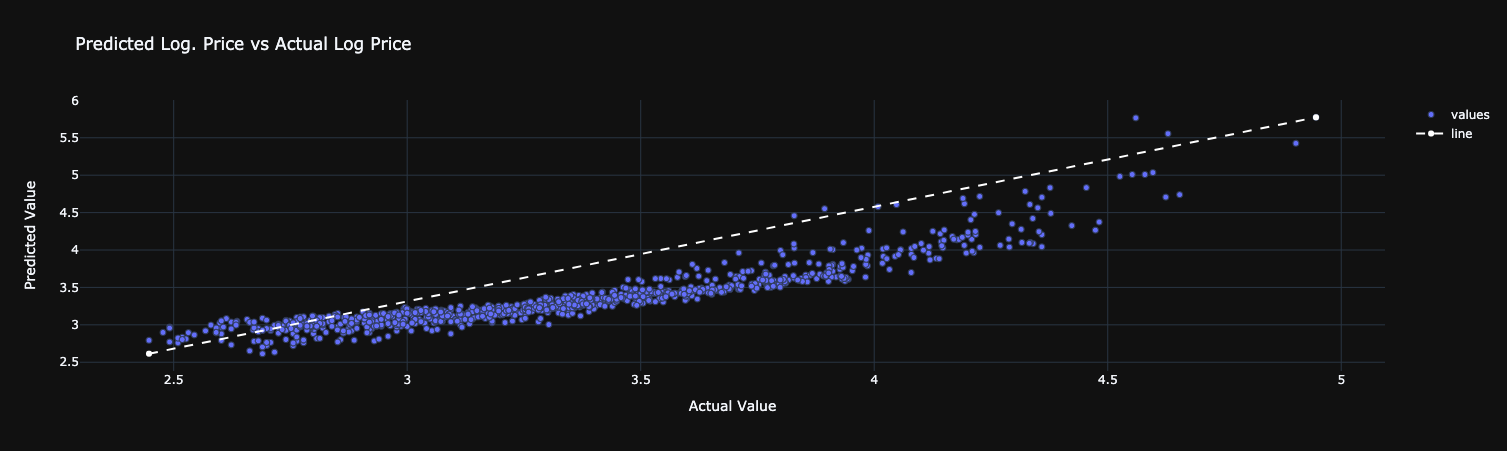

In [19]:
graph_df = pd.DataFrame(data={
    'actual_price': test_labels.values,
    'predicted_price': results.predict(sm.add_constant(test_features))
}).sample(1000, random_state=0)


fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = graph_df.actual_price
        , y = graph_df.predicted_price
        , mode='markers'
        , name='values'
        , marker=dict(
            colorscale='agsunset',
            line_width=1
        )
    )
)
 
fig.add_trace(
    go.Scatter(
        x=[graph_df.actual_price.min(), graph_df.actual_price.max()]
        , y = [graph_df.predicted_price.min(), graph_df.predicted_price.max()]
        , name='line'
        , line=dict(
            dash='dash', 
            color='white',
        )
    )
)

# dark theme 
fig.layout.template = 'plotly_dark'


fig.update_layout(title = 'Predicted Log. Price vs Actual Log Price',
                  xaxis_title='Actual Value',
                  yaxis_title='Predicted Value', 
                 )

fig.show()

In [20]:
### calc mse
mse = sum((graph_df.actual_price - graph_df.predicted_price)**2)/graph_df.shape[0]

print(mse)

0.03266768626875111


### XGB

In [53]:
## test and train
train_dataset = diamond_df_t.copy().sample(frac=0.8, random_state=0)
test_dataset = diamond_df_t.copy().drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('log_price')
test_labels = test_features.pop('log_price')

In [54]:
# ## cross validation dmatrix
y = test_labels.append(train_labels).reset_index(drop=True)
X = test_features.append(train_features).reset_index(drop=True)

cv_dmatrix = xgb.DMatrix(data=X,label=y)

In [55]:
xg_reg = xgb.XGBRegressor(
    objective ='reg:squarederror', 
    colsample_bytree = 0.3, 
    learning_rate = 0.1,
    max_depth = 5, 
    alpha = 10, 
    n_estimators = 500
)

In [56]:
xg_reg.fit(train_features, train_labels)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Well, how is it?

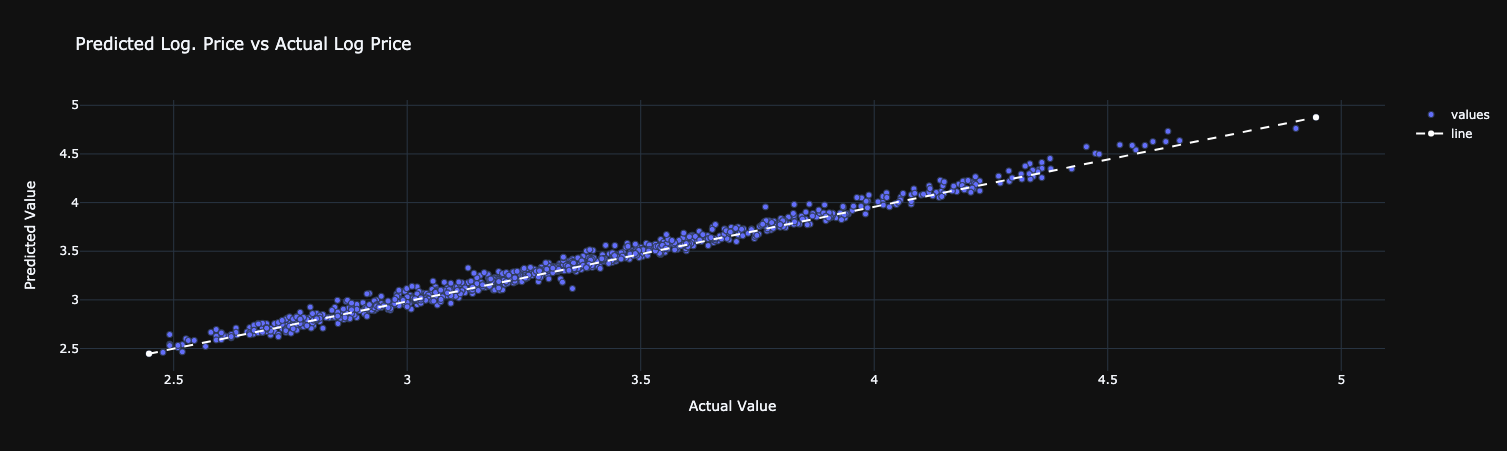

In [57]:
graph_df = pd.DataFrame(data={
    'actual_price': test_labels.values,
    'predicted_price': xg_reg.predict(test_features)
}).sample(1000, random_state=0)

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = graph_df.actual_price
        , y = graph_df.predicted_price
        , mode='markers'
        , name='values'
        , marker=dict(
            colorscale='agsunset',
            line_width=1
        )
    )
)
 
fig.add_trace(
    go.Scatter(
        x=[graph_df.actual_price.min(), graph_df.actual_price.max()]
        , y = [graph_df.predicted_price.min(), graph_df.predicted_price.max()]
        , name='line'
        , line=dict(
            dash='dash', 
            color='white',
        )
    )
)

# dark theme 
fig.layout.template = 'plotly_dark'


fig.update_layout(title = 'Predicted Log. Price vs Actual Log Price',
                  xaxis_title='Actual Value',
                  yaxis_title='Predicted Value', 
                 )

fig.show()

In [58]:
### calc mse
mse = sum((graph_df.actual_price - graph_df.predicted_price)**2)/graph_df.shape[0]

print(mse)

0.0023696878904453777


Explaining things with SHAP

In [59]:
shap_test_features = test_features.sample(n=1000, random_state=0)
shap_values = shap.TreeExplainer(xg_reg).shap_values(shap_test_features)

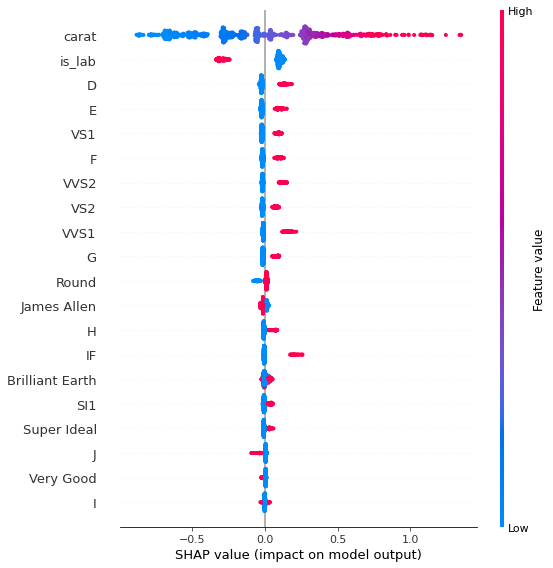

In [60]:
shap.summary_plot(shap_values, shap_test_features)

A couple single values

In [66]:
random.seed(a=1)
r_int1 = random.randint(0,999)
r_int2 = random.randint(0,999)
r_int3 = random.randint(0,999)

shap_xgb_model = shap.TreeExplainer(xg_reg)

In [62]:
shap.initjs()

In [67]:
## example 1
print(shap_test_features.iloc[r_int1,:].T)
shap.force_plot(shap_xgb_model.expected_value, shap_values[r_int1,:], shap_test_features.iloc[r_int1,:])

carat              3.03
is_lab             1.00
Asscher            0.00
Cushion            0.00
Heart              0.00
Marquise           0.00
Oval               0.00
Pear               0.00
Princess           0.00
Radiant            0.00
Round              1.00
Good               0.00
Ideal              1.00
Super Ideal        0.00
Very Good          0.00
D                  0.00
E                  0.00
F                  1.00
G                  0.00
H                  0.00
I                  0.00
J                  0.00
FL                 0.00
I1                 0.00
IF                 0.00
SI1                0.00
VS1                0.00
VS2                1.00
VVS1               0.00
VVS2               0.00
Brilliant Earth    1.00
James Allen        0.00
Name: 201050, dtype: float64


In [68]:
## example 2 
print(shap_test_features.iloc[r_int2,:].T)
shap.force_plot(shap_xgb_model.expected_value, shap_values[r_int2,:], shap_test_features.iloc[r_int2,:])

carat              0.41
is_lab             0.00
Asscher            0.00
Cushion            0.00
Heart              0.00
Marquise           0.00
Oval               0.00
Pear               0.00
Princess           0.00
Radiant            0.00
Round              1.00
Good               0.00
Ideal              1.00
Super Ideal        0.00
Very Good          0.00
D                  0.00
E                  0.00
F                  0.00
G                  1.00
H                  0.00
I                  0.00
J                  0.00
FL                 0.00
I1                 0.00
IF                 0.00
SI1                1.00
VS1                0.00
VS2                0.00
VVS1               0.00
VVS2               0.00
Brilliant Earth    0.00
James Allen        1.00
Name: 345274, dtype: float64


In [69]:
## example 3
print(shap_test_features.iloc[r_int2,:].T)
shap.force_plot(shap_xgb_model.expected_value, shap_values[r_int3,:], shap_test_features.iloc[r_int3,:])

carat              0.41
is_lab             0.00
Asscher            0.00
Cushion            0.00
Heart              0.00
Marquise           0.00
Oval               0.00
Pear               0.00
Princess           0.00
Radiant            0.00
Round              1.00
Good               0.00
Ideal              1.00
Super Ideal        0.00
Very Good          0.00
D                  0.00
E                  0.00
F                  0.00
G                  1.00
H                  0.00
I                  0.00
J                  0.00
FL                 0.00
I1                 0.00
IF                 0.00
SI1                1.00
VS1                0.00
VS2                0.00
VVS1               0.00
VVS2               0.00
Brilliant Earth    0.00
James Allen        1.00
Name: 345274, dtype: float64


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


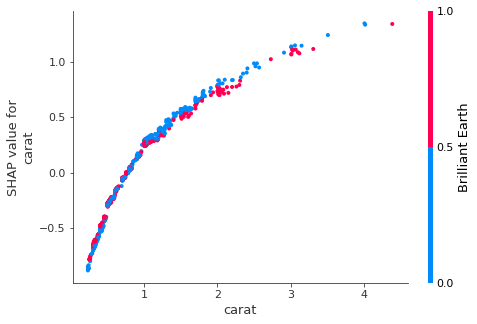

In [72]:
# relationship with carat
shap.dependence_plot('carat', shap_values, shap_test_features)

In [73]:
# get interaction values
shap_interaction_values = shap.TreeExplainer(xg_reg).shap_interaction_values(shap_test_features)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


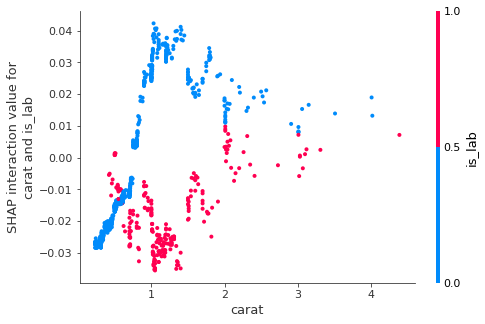

In [74]:
# lab and carat
shap.dependence_plot(('carat','is_lab'), shap_interaction_values, shap_test_features)

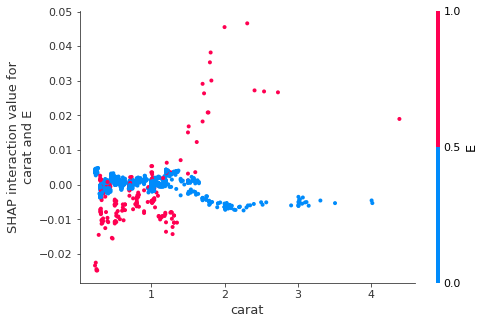

In [76]:
# carat and color
shap.dependence_plot(('carat','E'), shap_interaction_values, shap_test_features)

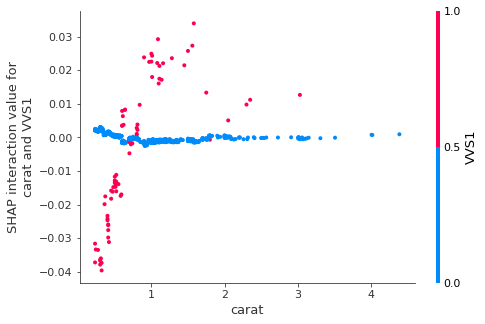

In [80]:
# carat and clarity
shap.dependence_plot(('carat','VVS1'), shap_interaction_values, shap_test_features)

### Fun with Tensorflow

basically just following [this tutorial](https://www.tensorflow.org/tutorials/keras/regression)

In [34]:
## test and train
train_dataset = diamond_df_t.copy().sample(frac=0.8, random_state=0)
test_dataset = diamond_df_t.copy().drop(train_dataset.index)


In [35]:
print(train_dataset.shape, test_dataset.shape)

(461453, 33) (115363, 33)


In [36]:
## test and train
## only using 100k samples to train
train_dataset = diamond_df_t.sample(n=100000, random_state=0)
test_dataset = diamond_df_t.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('log_price')
test_labels = test_features.pop('log_price')

train_dataset.shape

(100000, 33)

In [37]:
## Normalization

# create normalization layer
normalizer = preprocessing.Normalization()
# apply normalization to training data
normalizer.adapt(np.array(train_features))

first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first,'\n')
  print('Normalized:', normalizer(first).numpy())

First example: [[0.3 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0. ]] 

Normalized: [[-1.   -0.58 -0.05 -0.12 -0.06 -0.07 -0.22 -0.16 -0.13 -0.07  0.4  -0.17
   0.76 -0.45 -0.45 -0.45 -0.5   2.33 -0.42 -0.36 -0.33 -0.29 -0.05 -0.13
  -0.19  1.98 -0.49 -0.51 -0.28 -0.38  1.35 -1.  ]]


### DNN Model

In [38]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
        optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [39]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 32)                65        
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,402
Trainable params: 6,337
Non-trainable params: 65
_________________________________________________________________


In [40]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 4min 46s, sys: 1min 8s, total: 5min 54s
Wall time: 3min 11s


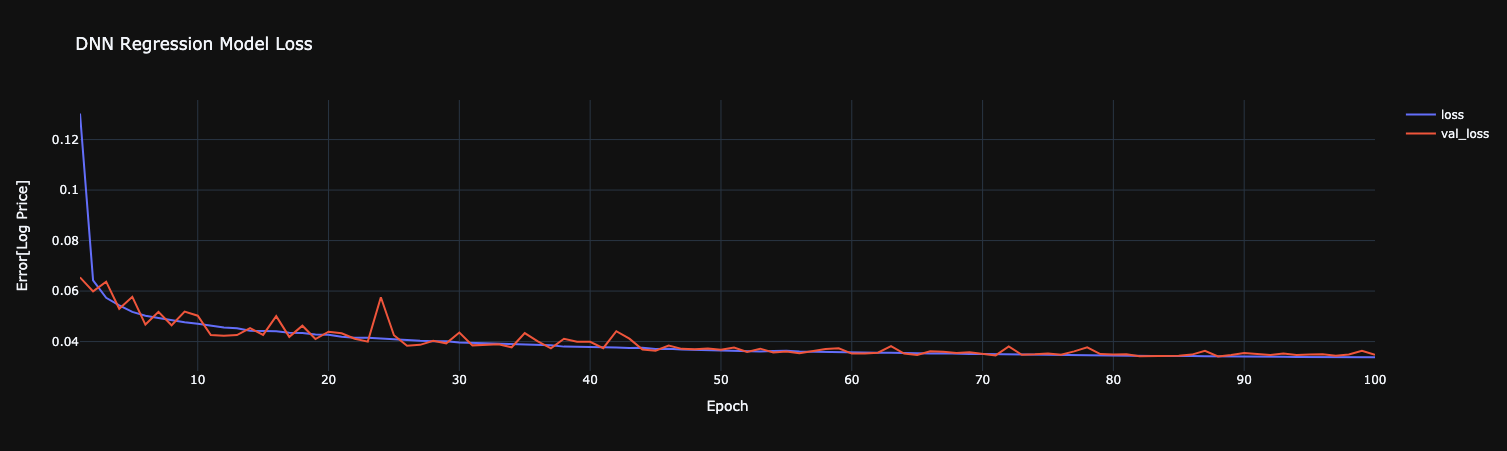

In [41]:
### plot loss
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = [n for n in range(1,101)]
        , y = history.history['loss']
        , name = 'loss'
        , marker=dict(
            colorscale='agsunset',
            line_width=1
        )
        
    )
)

fig.add_trace(
    go.Scatter(
        x = [n for n in range(1,101)]
        , y = history.history['val_loss']
        , name = 'val_loss'
        , marker=dict(
            colorscale='agsunset',
            line_width=1
        )
        
    )
)

# dark theme 
fig.layout.template = 'plotly_dark'


fig.update_layout(title = 'DNN Regression Model Loss',
                  xaxis_title='Epoch',
                  yaxis_title='Error[Log Price]', 
                 )

fig.show()

In [42]:
### predictions 
test_predictions = dnn_model.predict(test_features).flatten()


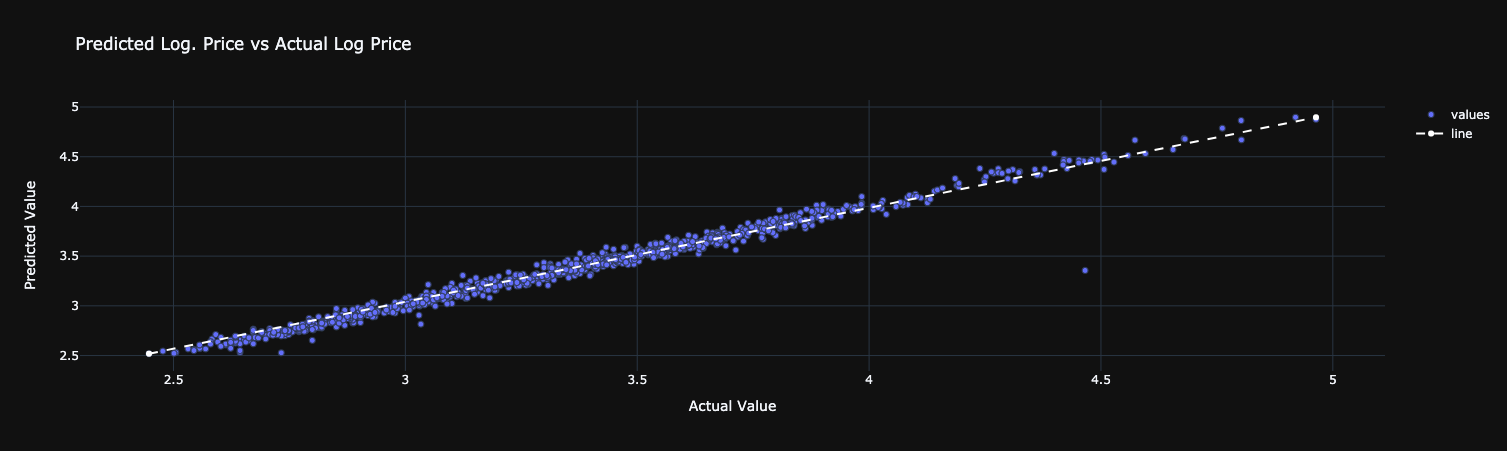

In [43]:
graph_df = pd.DataFrame(data = {
    'actual_price': test_labels, 
    'predicted_price': test_predictions
    }
).sample(n=1000, random_state=0)

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = graph_df.actual_price
        , y = graph_df.predicted_price
        , mode='markers'
        , name='values'
        , marker=dict(
            colorscale='agsunset',
            line_width=1,
        )
    )
)
 
fig.add_trace(
    go.Scatter(
        x=[graph_df.actual_price.min(), graph_df.actual_price.max()]
        , y = [graph_df.predicted_price.min(), graph_df.predicted_price.max()]
        , name='line'
        , line=dict(
            dash='dash', 
            color='white',
        )
    )
)

# dark theme 
fig.layout.template = 'plotly_dark'


fig.update_layout(title = 'Predicted Log. Price vs Actual Log Price',
                  xaxis_title='Actual Value',
                  yaxis_title='Predicted Value', 
                 )

fig.show()

In [52]:
### calc mse
mse = sum((graph_df.actual_price - graph_df.predicted_price)**2)/graph_df.shape[0]

print(mse)

0.0033811637051119323


### SHAP
#### Using SHAP to look into the black box

In [44]:
# # print the JS visualization code to the notebook
# shap.initjs()

In [45]:
# ### predict function
# def f(X):
#     return dnn_model.predict([X[:,i] for i in range(X.shape[1])]).flatten()

In [46]:
# # explain 100 the predictions in the test set
# sample_train_data = train_features.sample(n=100, random_state=0)
# explainer = shap.KernelExplainer(f, sample_train_data)
# # explainer = shap.DeepExplainer(dnn_model, sample_train_data)

In [47]:
# sample_test_data = test_features.sample(n=200, random_state=0)

# shap_values = explainer.shap_values(sample_test_data)
# shap.summary_plot(shap_values, sample_test_data)

In [48]:
# shap.force_plot(explainer.expected_value, shap_values, sample_test_data)

In [49]:
# shap.dependence_plot("carat", shap_values, sample_test_data)

In [50]:
# shap.dependence_plot("Round", shap_values, sample_test_data)

In [51]:
# sample_test_data.head()

### Misc